In [11]:
# if necessary, install NeuralGCM and dependencies
!python --version
!pip install -q -U neuralgcm dinosaur-dycore gcsfs

Python 3.12.2


/home/sarai-pc-02/miniconda3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Forecasting quick start

This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

The forecast is made in 3 steps:
1. Slice of ERA5 data is regridded to model resolution
2. NeuralGCM model state is initialized and rolled out
3. Predictions and reference trajectory are combined for visualization

By default the notebook uses intermediate deterministic NeuralGCM 1.4° model. Other available checkpoints include deterministic 0.7°, 2.8° and stochastic 1.4° NeuralGCM variations.

```{tip}
You can run this notebook yourself in [Google Colab](https://colab.research.google.com/github/google-research/neuralgcm/blob/main/docs/inference_demo.ipynb). We recommend using a GPU or TPU runtime due to high memory and compute requirements.
```

In [12]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

gcs = gcsfs.GCSFileSystem(token='anon')

In [13]:
! pip install xarray netCDF4 numpy

import xarray as xr

ersst_path = "./data/tos_Omon_GISS-E2-1-G_historical_r1i1p5f1_gn_200101-201412.nc"
ersst_data = xr.open_dataset(ersst_path)

Subset the data to be similar to NeuralGCM

## Load a pre-trained NeuralGCM model

```{caution}
Trained model weights are licensed for non-commercial use, under the Creative Commons [Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/) license (CC BY-NC-SA 4.0).
```

Pre-trained model checkpoints from the NeuralGCM paper are [available for download](https://console.cloud.google.com/storage/browser/gresearch/neuralgcm/04_30_2024) on Google Cloud Storage:

- Deterministic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl`
- Stochastic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl`

<span style="color:green">NEW</span> 
## Need to train it on our own using the inputs from era5

In [14]:
drought_variables = [
    "precipitation",      # To track precipitation deficits
    "evaporation",        # Water loss through evaporation
    "soil_moisture",      # Soil water content for agricultural impacts
    "temperature",        # High temperatures linked to drought
    "specific_humidity",  # Tracks atmospheric moisture
    "surface_pressure",   # Indicator of regional pressure systems
    "sea_surface_temp",   # SST anomalies linked to teleconnections
]

<span style="color:red">Training? What data (move to part where we use that data)</span>

In [15]:
model_name = 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

##
# TODO: Train on our own, Decide on training and testing data and do the 30 year roll out
# 
# 


/tmp/ipykernel_20907/1675669850.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  ckpt = pickle.load(f)


## Load ERA5 data from GCP/Zarr

See {doc}`datasets` for details. Leave this part


Select out a few days of data:

## Need to change start time and end time

Checklist: \
~~Select spain as a region~~ \
<span style="color:red">Decide on start and end time</span> \
<span style="color:green">NEW</span>Training better after loding data, as we use era5 as input? \
<span style="color:green">NEW</span>Maybe move this section to later, as we wrok here with sst so the full_era5 is a bit confusing here


In [16]:
#era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
#full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

#used for training as it is short, however empty amo_index 
start_date = '2014-12-11'
end_date = '2014-12-20'


#too long for training, but AMO is not empty
#start_date = '2001-12-10'
#end_date = '2014-12-20'


data_inner_steps = 24  # process every 24th hour

# Define the latitude and longitude bounds for Spain
# Die Werte müssen eigentlich größer sein, da im Mittelmeer auch Abläufe sind, die das beeinflussen. Für die Fläche 

lat_bounds = slice(34, 45)  # Latitude range for Spain mainland
lon_bounds = slice(-24, 4)  # Longitude range for Spain mainland

<span style="color:green">NEW</span>Subset the data before adding it to era5 input for the model \
<span style="color:green">NEW</span>Data in ersst_data is only from Jan 2001 til Jan 2014. changed the start and end_date for testing purposes. ALso why constricting the time?

<span style="color:green">NEW</span> Compute anomalies, trends, or indices such as the Atlantic Multidecadal Oscillation (AMO) to understand SST variations over time. \
<span style="color:green">NEW</span> Moved subset the data here, as I needed the todatetimeindex conversion later. With 2 seperate cells however I couldn't run this cell multiple times due to it

In [17]:
# Subset the data
sst_subset = ersst_data['tos'].sel(time=slice(start_date, end_date),
                                   lat=lat_bounds,
                                   lon=lon_bounds)

# Calculate the climatology (mean over the period)
sst_subset['time'] = sst_subset.indexes['time'].to_datetimeindex()

climatology = sst_subset.groupby('time').mean('time')

# Compute SST anomalies
sst_anomalies = sst_subset.groupby('time') - climatology

# Calculate the AMO index (example)
amo_index = sst_anomalies.mean(dim=['lat', 'lon'])
print(sst_anomalies)

<xarray.DataArray 'tos' (time: 1, lat: 4, lon: 2)> Size: 32B
array([[[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [nan,  0.]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 32B 37.0 39.0 41.0 43.0
  * lon      (lon) float64 16B 1.25 3.75
  * time     (time) datetime64[ns] 8B 2014-12-16T12:00:00


/tmp/ipykernel_20907/3373846938.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sst_subset['time'] = sst_subset.indexes['time'].to_datetimeindex()


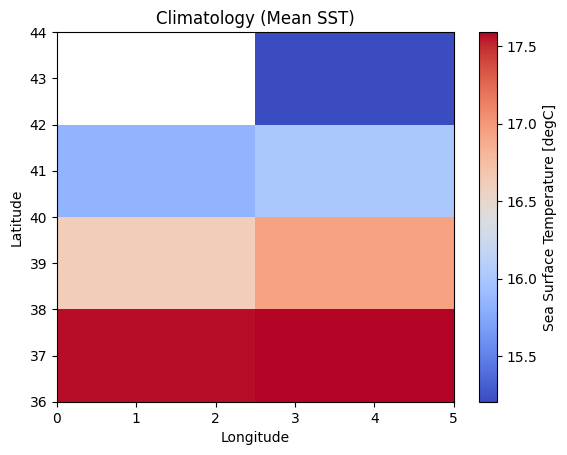

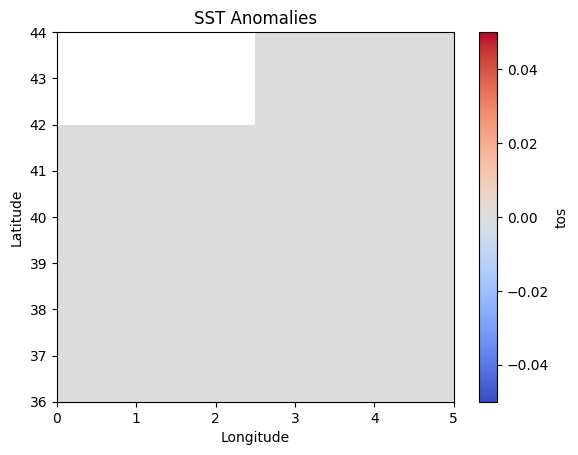

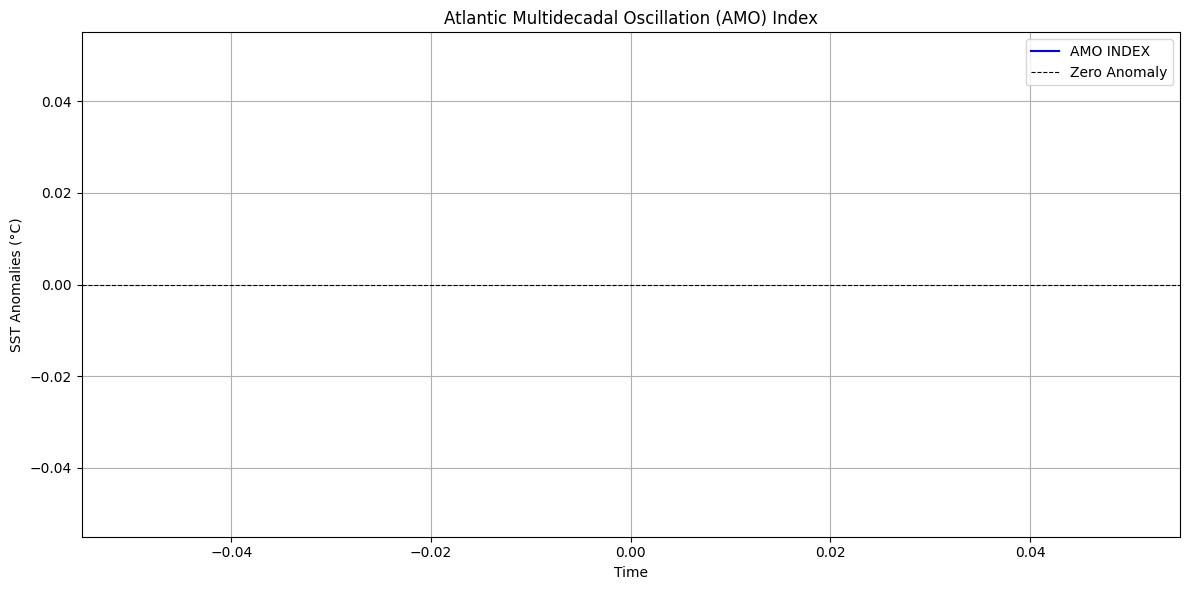

In [19]:
# TODO Modify plots (not very meaningful) 
import matplotlib.pyplot as plt

climatology.isel(time=0).plot(cmap='coolwarm')
plt.title("Climatology (Mean SST)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

sst_anomalies.isel(time=0).plot(cmap='coolwarm')
plt.title("SST Anomalies")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(amo_index, label="AMO INDEX", color="b")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8, label="Zero Anomaly")
plt.title("Atlantic Multidecadal Oscillation (AMO) Index")
plt.xlabel("Time")
plt.ylabel("SST Anomalies (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="color:green">NEW</span>Incorporate the processed SST data or derived indices into your drought prediction model as predictors or covariates.

In [49]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

precipitation_data = full_era5['mean_total_precipitation_rate'] #idk if it is precipitation TODO: print variable names to know
temperature_data = full_era5['temperature']

model_inputs = {
    'precipitation': precipitation_data,
    'temperature': temperature_data,
    'sst_anomalies': sst_anomalies,
    # TODO: Add other variables as needed
}

In [44]:
sst_anomalies = sst_anomalies.rename({'lat': 'latitude', 'lon': 'longitude'})
print(sst_anomalies.dims)

('time', 'latitude', 'longitude')


In [45]:
print(full_era5["mean_total_precipitation_rate"])
for i in full_era5:
    if "pre" in i:
        print(i)

<xarray.DataArray 'mean_total_precipitation_rate' (time: 1323648,
                                                   latitude: 721,
                                                   longitude: 1440)> Size: 5TB
[1374264299520 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   Mean total precipitation rate
    short_name:  mtpr
    units:       kg m**-2 s**-1
10m_wind_gust_since_previous_post_processing
convective_precipitation
instantaneous_large_scale_surface_precipitation_fraction
large_scale_precipitation
large_scale_precipitation_fraction
maximum_2m_temperature_since_previous_post_processing
maximum_total_precipitation_rate_since_previous_post_processing
mean_convective_precipitation_rate
mean_large_scale_precipitation_fraction
mean_la

<span style="color:green">NEW</span> Add SST anomalies to the input variables of the NeuralGCM model
<span style="color:green">TODO</span> Error with too much data -> sliced or maybe on cluster

In [51]:
# Add SST anomalies to the input variables of the NeuralGCM model
era5_with_sst = xr.Dataset(
    {
        'precipitation': full_era5['mean_total_precipitation_rate'],
        'temperature': full_era5['temperature'],
        'specific_humidity': full_era5['specific_humidity'],
        'sst_anomalies': sst_anomalies,
        # TODO: ADD remining inputs
    },
    coords={
        'time': full_era5['time'],
        'latitude': full_era5['latitude'],
        'longitude': full_era5['longitude'],
    }
)

MemoryError: Unable to allocate 5.00 TiB for an array with shape (1323648, 721, 1440) and data type float32

Regrid to NeuralGCM's native resolution: <span style="color:red">Rewrite it to use the sst data</span>.

In [40]:
#start_date_test = "2014-12-10"
#end_date_test = "2014-12-20"

sliced_era5 = (
    full_era5[['mean_total_precipitation_rate', 'temperature']]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=[],
        time_shift='24 hours',
    )
    .sel(time=slice(start_date, end_date, data_inner_steps))
    .compute()
)


sliced_era5['sst_anomalies'] = sst_anomalies.sel(
    time=slice(start_date, end_date)
)

In [41]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

ValueError: Missing core dims {'latitude', 'longitude'} from arg number 1 on a variable named `sst_anomalies`:
<xarray.Variable (time: 10, lat: 4, lon: 2)> Size: 320B
array([[[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]],

...

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]]], dtype=float32)

Either add the core dimension, or if passing a dataset alternatively pass `on_missing_core_dim` as `copy` or `drop`. 

In [42]:
print(sst_anomalies.dims)

('time', 'lat', 'lon')


<span style="color:green">NEW</span>:Ensure that the combined dataset adheres to NeuralGCM’s expected format.

In [145]:
model_inputs = {
    variable: era5_with_sst[variable].values for variable in era5_with_sst.data_vars
}

MemoryError: Unable to allocate 5.00 TiB for an array with shape (1323648, 721, 1440) and data type float32

## Make the forecast

See {doc}`trained_models` for details.

In [ ]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
# TODO: change the input with the new one


inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

Can stay like this

In [ ]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

In [ ]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);

## Data Analysis